In [58]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left[-\frac{1}{\xi_a}(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\right]\pi_j^o
$$

FOC of $h_2$ gives : 

\begin{align}
h_2^* = -\frac{\frac{\partial \phi}{\partial z_2}(y, z_2)\sqrt{z_2}\sigma_2 + (\eta-1)\sum_{j}^J \pi_j \frac{d}{d \tau}\Lambda_j(z_2 y)\left(y\sqrt{z_2}\sigma_2\right)}{\xi_m}
\end{align}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2) + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(z_2 y)z_2}
$$

In [67]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    Λ_first_der = np.array([λ_1 + λ_2*y_mat*z_mat + 
                            λ_2p_j*(y_mat*z_mat>λ_bar)*(y_mat*z_mat-λ_bar) for λ_2p_j in λ_2p])
    Λ_second_der = np.array([λ_2 + λ_2p_j*(y_mat*z_mat>λ_bar) for λ_2p_j in λ_2p])
    der_yz_sigma = Λ_first_der*y_mat*np.sqrt(z_mat)*σ_2
    der_z = Λ_first_der*z_mat

    π = np.ones_like(Λ_first_der)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
    π_o = π.copy()
    h = (1-η)/ξ_m * np.sum(π*der_yz_sigma, axis=0)
    e = -δ*η/((η-1)*np.sum(π*der_z, axis=0))

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        temp = Λ_first_der*(z_mat*e - y_mat*ρ*(z_mat-μ_2) + y_mat*np.sqrt(z_mat)*σ_2*h)\
               + 0.5*Λ_second_der*z_mat*y_mat**2*σ_2**2
        log_π_ratio = -1./ξ_a*(η-1.)*temp
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-10

        h = - (v0_dz*np.sqrt(z_mat)*σ_2 + (η-1)*np.sum(π*der_yz_sigma, axis=0)) / ξ_m
        e = - δ*η / (v0_dy + (η-1)*np.sum(π*der_z, axis=0))
        e[e<=0] = 1e-10

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*np.sum(π*temp, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [97]:
# Model parameters
η = .032
# ξ_m = .00256
# ξ_a = .001
ξ_m = 1000.
ξ_a = 1000.
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
# λ_2p = np.array([0., 0.0197*2, 0.3853*2])
# π_o = np.array([0.475, 0.475, 0.05])

# two damage
λ_2p = np.array([0., 0.0197*2])
π_o = np.array([0.5, 0.5])

pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

In [ ]:
ϕ_grid, e_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                 v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.1519642916670514; RHS Error 0.23052375453414356
Iteration 2: LHS Error: 0.10225479216359057; RHS Error 0.15161687027548837
Iteration 3: LHS Error: 0.07040739435889143; RHS Error 0.10190195525119607
Iteration 4: LHS Error: 0.04979212142758804; RHS Error 0.0701571575225314
Iteration 5: LHS Error: 0.03628780872474913; RHS Error 0.049609402088271054
Iteration 6: LHS Error: 0.0273501463486181; RHS Error 0.03614996904971132
Iteration 7: LHS Error: 0.021382143703650103; RHS Error 0.027242382929650227
Iteration 8: LHS Error: 0.017366125313302616; RHS Error 0.021294676315959882
Iteration 9: LHS Error: 0.014644776536676174; RHS Error 0.017292439285070543
Iteration 10: LHS Error: 0.012788543072350889; RHS Error 0.014580504615970769
Iteration 11: LHS Error: 0.011513624709263093; RHS Error 0.01273074341786734
Iteration 12: LHS Error: 0.010632053533617514; RHS Error 0.011460410299750617
Iteration 13: LHS Error: 0.010016897124437651; RHS Error 0.010581956486729133
Iteration 

Iteration 108: LHS Error: 0.005532789841687036; RHS Error 0.005531944301893341
Iteration 109: LHS Error: 0.0055061037488701725; RHS Error 0.005505260277921406
Iteration 110: LHS Error: 0.0054795483472036555; RHS Error 0.005478706942127695
Iteration 111: LHS Error: 0.005453122998061222; RHS Error 0.005452283652961756
Iteration 112: LHS Error: 0.005426827045915017; RHS Error 0.005425989763664485
Iteration 113: LHS Error: 0.005400659853044942; RHS Error 0.005399824628547059
Iteration 114: LHS Error: 0.005374620774362571; RHS Error 0.005373787610817984
Iteration 115: LHS Error: 0.005348709172252164; RHS Error 0.005347878070137133
Iteration 116: LHS Error: 0.005322924286732755; RHS Error 0.005322095369589691
Iteration 117: LHS Error: 0.005297265796828432; RHS Error 0.005296438881119289
Iteration 118: LHS Error: 0.005271732861257039; RHS Error 0.005270908044259767
Iteration 119: LHS Error: 0.0052463248633447535; RHS Error 0.0052455021317238115
Iteration 120: LHS Error: 0.005221041192828624; 

Iteration 212: LHS Error: 0.0033525467248637364; RHS Error 0.0033519156983840143
Iteration 213: LHS Error: 0.00333649345159559; RHS Error 0.0033358644019314543
Iteration 214: LHS Error: 0.003320518044083065; RHS Error 0.003319890975111997
Iteration 215: LHS Error: 0.0033046201174481427; RHS Error 0.0033039950243279465
Iteration 216: LHS Error: 0.0032887990168574133; RHS Error 0.0032881761679016963
Iteration 217: LHS Error: 0.0032730550510464695; RHS Error 0.003272434022416018
Iteration 218: LHS Error: 0.003257387329497319; RHS Error 0.003256768375083985
Iteration 219: LHS Error: 0.0032417955269872234; RHS Error 0.0032411785921191844
Iteration 220: LHS Error: 0.003226279305278301; RHS Error 0.0032256643574627986
Iteration 221: LHS Error: 0.003210838072845945; RHS Error 0.00321022531903431
Iteration 222: LHS Error: 0.0031954719919643493; RHS Error 0.0031948611072565164
Iteration 223: LHS Error: 0.0031801805829649865; RHS Error 0.003179571485863744
Iteration 224: LHS Error: 0.003164962553

Iteration 316: LHS Error: 0.0020379879962070246; RHS Error 0.0020375527764084356
Iteration 317: LHS Error: 0.0020282818050286755; RHS Error 0.0020278482856971175
Iteration 318: LHS Error: 0.0020186222281927124; RHS Error 0.0020181904035475595
Iteration 319: LHS Error: 0.0020090090376154723; RHS Error 0.002008578904123745
Iteration 320: LHS Error: 0.001999442007144414; RHS Error 0.001999013559584137
Iteration 321: LHS Error: 0.0019899209103226845; RHS Error 0.001989494144549797
Iteration 322: LHS Error: 0.0019804455230856277; RHS Error 0.001980020434086696
Iteration 323: LHS Error: 0.001971015621996197; RHS Error 0.0019705922045094026
Iteration 324: LHS Error: 0.0019616309842448443; RHS Error 0.0019612092369741957
Iteration 325: LHS Error: 0.001952291389125449; RHS Error 0.0019518713014334277
Iteration 326: LHS Error: 0.0019429966163013734; RHS Error 0.0019425781838200568
Iteration 327: LHS Error: 0.0019337471905653825; RHS Error 0.001933329663356062
Iteration 328: LHS Error: 0.00192454

Iteration 419: LHS Error: 0.00124738602656016; RHS Error 0.0012471022277040916
Iteration 420: LHS Error: 0.0012414624919062645; RHS Error 0.0012411799560005377
Iteration 421: LHS Error: 0.001235567392465331; RHS Error 0.0012352859110398157
Iteration 422: LHS Error: 0.001229699853704691; RHS Error 0.001229419972611459
Iteration 423: LHS Error: 0.0012238608704634446; RHS Error 0.0012235818314184355
Iteration 424: LHS Error: 0.001218049345451; RHS Error 0.001217771732825182
Iteration 425: LHS Error: 0.0012122655587141207; RHS Error 0.0012119891415493522
Iteration 426: LHS Error: 0.0012065093476176791; RHS Error 0.0012062341518604275
Iteration 427: LHS Error: 0.001200780564362014; RHS Error 0.0012005066024607103
Iteration 428: LHS Error: 0.0011950790754226004; RHS Error 0.0011948063447193569
Iteration 429: LHS Error: 0.0011894049023832842; RHS Error 0.0011891332442602043
Iteration 430: LHS Error: 0.0011837575473927497; RHS Error 0.0011834871755367904
Iteration 431: LHS Error: 0.00117813704

Iteration 521: LHS Error: 0.0007678019733899921; RHS Error 0.0007676233563006923
Iteration 522: LHS Error: 0.0007641585637915838; RHS Error 0.0007639808081931904
Iteration 523: LHS Error: 0.0007605324376132039; RHS Error 0.0007603555407870721
Iteration 524: LHS Error: 0.0007569235141555164; RHS Error 0.00075674747475378
Iteration 525: LHS Error: 0.0007533317095835268; RHS Error 0.000753156523634127
Iteration 526: LHS Error: 0.0007497569430222062; RHS Error 0.0007495826030381042
Iteration 527: LHS Error: 0.0007461991314382521; RHS Error 0.0007460256397455456
Iteration 528: LHS Error: 0.0007426581958476786; RHS Error 0.0007424855461350133
Iteration 529: LHS Error: 0.0007391343258753569; RHS Error 0.0007389622404408158
Iteration 530: LHS Error: 0.0007356267331727895; RHS Error 0.0007354556504675924
Iteration 531: LHS Error: 0.0007321369168288294; RHS Error 0.0007319655222344373
Iteration 532: LHS Error: 0.0007286618772512354; RHS Error 0.0007284920421339047
Iteration 533: LHS Error: 0.000

Iteration 623: LHS Error: 0.000472588381717598; RHS Error 0.0004724856963523316
Iteration 624: LHS Error: 0.0004703440846243745; RHS Error 0.0004702420286174236
Iteration 625: LHS Error: 0.0004681104165871752; RHS Error 0.0004680089927826814
Iteration 626: LHS Error: 0.0004658873754948001; RHS Error 0.0004657865285837004
Iteration 627: LHS Error: 0.0004636747278684572; RHS Error 0.0004635746591972467
Iteration 628: LHS Error: 0.0004614726686682502; RHS Error 0.0004613730782788428
Iteration 629: LHS Error: 0.00045928102436237905; RHS Error 0.0004591820613885911
Iteration 630: LHS Error: 0.0004570997531402887; RHS Error 0.0004570014140363732
Iteration 631: LHS Error: 0.0004549288115806016; RHS Error 0.0004548310864288807
Iteration 632: LHS Error: 0.0004527681494096436; RHS Error 0.00045267103208038173
Iteration 633: LHS Error: 0.00045061776935362285; RHS Error 0.00045052120351854463
Iteration 634: LHS Error: 0.00044847748799609066; RHS Error 0.00044838162755905797
Iteration 635: LHS Erro

Iteration 724: LHS Error: 0.00029209175482008964; RHS Error 0.0004570418522933384
Iteration 725: LHS Error: 0.000290702325540404; RHS Error 0.0004584309488678412
Iteration 726: LHS Error: 0.0002893194753972872; RHS Error 0.0004598134572417617
Iteration 727: LHS Error: 0.0002879431781908637; RHS Error 0.00046118942877718117
Iteration 728: LHS Error: 0.00028657340937543463; RHS Error 0.0004625588744347209
Iteration 729: LHS Error: 0.0002852101205627622; RHS Error 0.0004639218225920838
Iteration 730: LHS Error: 0.0002838532993673648; RHS Error 0.00046527832800215274
Iteration 731: LHS Error: 0.0002825028985806721; RHS Error 0.0004666283989948339
Iteration 732: LHS Error: 0.0002811589010283111; RHS Error 0.000467972073777842
Iteration 733: LHS Error: 0.0002798212742120554; RHS Error 0.0004693093826110828
Iteration 734: LHS Error: 0.00027848997512303075; RHS Error 0.0004706403455487368
Iteration 735: LHS Error: 0.00027716499400792793; RHS Error 0.0004719650211504056
Iteration 736: LHS Error

Iteration 826: LHS Error: 0.00017950697041901886; RHS Error 0.0005695998611574132
Iteration 827: LHS Error: 0.00017865132219602176; RHS Error 0.0005704552545071628
Iteration 828: LHS Error: 0.00017779970596426553; RHS Error 0.0005713066520799254
Iteration 829: LHS Error: 0.00017695211882429174; RHS Error 0.0005721540317219082
Iteration 830: LHS Error: 0.00017610854971339407; RHS Error 0.0005729974003012561
Iteration 831: LHS Error: 0.00017526898234077048; RHS Error 0.0005738367706235453
Iteration 832: LHS Error: 0.00017443339743644648; RHS Error 0.0005746721593878623
Iteration 833: LHS Error: 0.00017360177849556901; RHS Error 0.0005755035833106409
Iteration 834: LHS Error: 0.00017277410513977243; RHS Error 0.0005763310634396696
Iteration 835: LHS Error: 0.00017195036074824088; RHS Error 0.0005771546129141047
Iteration 836: LHS Error: 0.00017113052359013503; RHS Error 0.00057797425903372
Iteration 837: LHS Error: 0.00017031457935051675; RHS Error 0.0005787900166963206
Iteration 838: LHS

Iteration 928: LHS Error: 0.00011019770007825169; RHS Error 0.0006388931572219453
Iteration 929: LHS Error: 0.00010967119614624377; RHS Error 0.000639419544326919
Iteration 930: LHS Error: 0.00010914719575211285; RHS Error 0.0006399434270252108
Iteration 931: LHS Error: 0.0001086256856376866; RHS Error 0.0006404648212623987
Iteration 932: LHS Error: 0.00010810665860339075; RHS Error 0.000640983734561229
Iteration 933: LHS Error: 0.00010759009827304711; RHS Error 0.0006415001781917423
Iteration 934: LHS Error: 0.00010707599426390546; RHS Error 0.0006420141685103409
Iteration 935: LHS Error: 0.00010656433647893149; RHS Error 0.000642525712840944
Iteration 936: LHS Error: 0.00010605511175953986; RHS Error 0.0006430348254138213
Iteration 937: LHS Error: 0.0001055483091174092; RHS Error 0.0006435415143446199
Iteration 938: LHS Error: 0.00010504391514454259; RHS Error 0.0006440457904516306
Iteration 939: LHS Error: 0.00010454192302478127; RHS Error 0.000644547677136828
Iteration 940: LHS Err

Iteration 1030: LHS Error: 6.757349964708892e-05; RHS Error 0.0006815080741247037
Iteration 1031: LHS Error: 6.724997402163257e-05; RHS Error 0.0006818315920134321
Iteration 1032: LHS Error: 6.692781079964405e-05; RHS Error 0.0006821535206403134
Iteration 1033: LHS Error: 6.660733026525589e-05; RHS Error 0.0006824740606240359
Iteration 1034: LHS Error: 6.628836303496088e-05; RHS Error 0.0006827929509249653
Iteration 1035: LHS Error: 6.597096393684554e-05; RHS Error 0.0006831103320036058
Iteration 1036: LHS Error: 6.565496176802466e-05; RHS Error 0.0006834261680778858
Iteration 1037: LHS Error: 6.534050333928398e-05; RHS Error 0.0006837405854090012
Iteration 1038: LHS Error: 6.502755117077097e-05; RHS Error 0.000684053477782165
Iteration 1039: LHS Error: 6.471609931013589e-05; RHS Error 0.0006843648711073597
Iteration 1040: LHS Error: 6.440612861247086e-05; RHS Error 0.000684674777104044
Iteration 1041: LHS Error: 6.409763942288871e-05; RHS Error 0.0006849832014978047
Iteration 1042: LH

Iteration 1131: LHS Error: 4.1590150719972296e-05; RHS Error 0.0007074861542770566
Iteration 1132: LHS Error: 4.139057334673346e-05; RHS Error 0.0007076856198545423
Iteration 1133: LHS Error: 4.119193911389374e-05; RHS Error 0.0007078842016717685
Iteration 1134: LHS Error: 4.099464594509161e-05; RHS Error 0.000708081852237849
Iteration 1135: LHS Error: 4.079758617742124e-05; RHS Error 0.0007082782452722258
Iteration 1136: LHS Error: 4.060160494240295e-05; RHS Error 0.0007084742771096553
Iteration 1137: LHS Error: 4.04067344855763e-05; RHS Error 0.0007086695113853736
Iteration 1138: LHS Error: 4.0213216395468265e-05; RHS Error 0.0007088631882014584
Iteration 1139: LHS Error: 4.001992763991158e-05; RHS Error 0.0007090557809322356
Iteration 1140: LHS Error: 3.9827744298337464e-05; RHS Error 0.0007092480638085513
Iteration 1141: LHS Error: 3.963652858357536e-05; RHS Error 0.0007094392800501836
Iteration 1142: LHS Error: 3.944624427859589e-05; RHS Error 0.0007096298326179085
Iteration 1143:

Iteration 1232: LHS Error: 2.5571534579160726e-05; RHS Error 0.0007235012359346066
Iteration 1233: LHS Error: 2.54483502312719e-05; RHS Error 0.0007236246252827899
Iteration 1234: LHS Error: 2.5325898606376462e-05; RHS Error 0.0007237471695193953
Iteration 1235: LHS Error: 2.5205937851269233e-05; RHS Error 0.0007238690008380538
Iteration 1236: LHS Error: 2.5083656550184408e-05; RHS Error 0.0007239911000863769
Iteration 1237: LHS Error: 2.4962512366721867e-05; RHS Error 0.0007241101494508684
Iteration 1238: LHS Error: 2.4842251586498776e-05; RHS Error 0.000724230617601393
Iteration 1239: LHS Error: 2.4722696314982695e-05; RHS Error 0.0007243502559128867
Iteration 1240: LHS Error: 2.4604282113926956e-05; RHS Error 0.0007244692037347705
Iteration 1241: LHS Error: 2.4520634963609567e-05; RHS Error 0.0007245881646190666
Iteration 1242: LHS Error: 2.438917605712687e-05; RHS Error 0.0007247046589719669
Iteration 1243: LHS Error: 2.4260662768893493e-05; RHS Error 0.0007248223814491361
Iteratio

Iteration 1333: LHS Error: 1.5704531106497388e-05; RHS Error 0.000733367194107909
Iteration 1334: LHS Error: 1.562885131106695e-05; RHS Error 0.0007334428607564947
Iteration 1335: LHS Error: 1.5553533380674445e-05; RHS Error 0.0007335181614123165
Iteration 1336: LHS Error: 1.547857894002025e-05; RHS Error 0.0007335931025939518
Iteration 1337: LHS Error: 1.540398239563423e-05; RHS Error 0.0007336676820908217
Iteration 1338: LHS Error: 1.5329746552661394e-05; RHS Error 0.0007337419055524347
Iteration 1339: LHS Error: 1.5255865422558745e-05; RHS Error 0.0007338157699509212
Iteration 1340: LHS Error: 1.5182340121100424e-05; RHS Error 0.0007338892811960124
Iteration 1341: LHS Error: 1.5109166286830789e-05; RHS Error 0.0007339624384959387
Iteration 1342: LHS Error: 1.503634665139808e-05; RHS Error 0.0007340352452083754
Iteration 1343: LHS Error: 1.4963874500950602e-05; RHS Error 0.0007341077018406666
Iteration 1344: LHS Error: 1.4891751290713184e-05; RHS Error 0.0007341798131047933
Iteration

Iteration 1433: LHS Error: 9.684050815639278e-06; RHS Error 0.0007393864496521158
Iteration 1434: LHS Error: 9.63730861280876e-06; RHS Error 0.0007394331809358057
Iteration 1435: LHS Error: 9.59078840179206e-06; RHS Error 0.0007394796896894318
Iteration 1436: LHS Error: 9.544498327795914e-06; RHS Error 0.0007395259771412338
Iteration 1437: LHS Error: 9.49842709219162e-06; RHS Error 0.0007395720362889102
Iteration 1438: LHS Error: 9.45257760420759e-06; RHS Error 0.0007396178751063048
Iteration 1439: LHS Error: 9.406949282864119e-06; RHS Error 0.00073966349759505
Iteration 1440: LHS Error: 9.361539618002457e-06; RHS Error 0.0007397088971221599
Iteration 1441: LHS Error: 9.316346037957501e-06; RHS Error 0.0007397540823441823
Iteration 1442: LHS Error: 9.27137800266209e-06; RHS Error 0.0007397990476376848
Iteration 1443: LHS Error: 9.226620301006072e-06; RHS Error 0.0007398437894757387
Iteration 1444: LHS Error: 9.182079033831503e-06; RHS Error 0.0007398883259192857
Iteration 1445: LHS Err

Iteration 1535: LHS Error: 5.90965345426131e-06; RHS Error 0.000743160525711481
Iteration 1536: LHS Error: 5.880781725919881e-06; RHS Error 0.0007431885360328488
Iteration 1537: LHS Error: 5.852652687932114e-06; RHS Error 0.0007432174960515237
Iteration 1538: LHS Error: 5.8240731089509445e-06; RHS Error 0.0007432452532577932
Iteration 1539: LHS Error: 5.796192617257834e-06; RHS Error 0.0007432739368834901
Iteration 1540: LHS Error: 5.767905006337504e-06; RHS Error 0.0007433014321027581
Iteration 1541: LHS Error: 5.740041645330152e-06; RHS Error 0.0007433298328971688
Iteration 1542: LHS Error: 5.712309489758205e-06; RHS Error 0.0007433574199231796
Iteration 1543: LHS Error: 5.685002557931362e-06; RHS Error 0.0007433849736436515
Iteration 1544: LHS Error: 5.657400178937788e-06; RHS Error 0.000743412080592698
Iteration 1545: LHS Error: 5.629823941255552e-06; RHS Error 0.000743439637121146
Iteration 1546: LHS Error: 5.603081601301962e-06; RHS Error 0.0007434672912619983
Iteration 1547: LHS

Iteration 1637: LHS Error: 3.6038551748385217e-06; RHS Error 0.0007454659749636522
Iteration 1638: LHS Error: 3.585930488769762e-06; RHS Error 0.0007454828388967355
Iteration 1639: LHS Error: 3.5685169784138715e-06; RHS Error 0.0007455009932333528
Iteration 1640: LHS Error: 3.5512469568343974e-06; RHS Error 0.0007455180372651499
Iteration 1641: LHS Error: 3.5340508390824255e-06; RHS Error 0.0007455351762395007
Iteration 1642: LHS Error: 3.5175034487355816e-06; RHS Error 0.0007455523058874786
Iteration 1643: LHS Error: 3.5001562326275604e-06; RHS Error 0.0007455687686219598
Iteration 1644: LHS Error: 3.4830756522330475e-06; RHS Error 0.0007455859784391283
Iteration 1645: LHS Error: 3.46611309470779e-06; RHS Error 0.0007456034742299167
Iteration 1646: LHS Error: 3.4493262578982886e-06; RHS Error 0.0007456200214652625
Iteration 1647: LHS Error: 3.433168862310154e-06; RHS Error 0.0007456366235258083
Iteration 1648: LHS Error: 3.416109593812333e-06; RHS Error 0.0007456526814719477
Iteration

Iteration 1737: LHS Error: 2.217348967881172e-06; RHS Error 0.000746851718146771
Iteration 1738: LHS Error: 2.206602455201434e-06; RHS Error 0.0007468624636917803
Iteration 1739: LHS Error: 2.195906451951668e-06; RHS Error 0.0007468731571683151
Iteration 1740: LHS Error: 2.1852645901154766e-06; RHS Error 0.0007468837986617516
Iteration 1741: LHS Error: 2.1746730407556925e-06; RHS Error 0.0007468943882803641
Iteration 1742: LHS Error: 2.1641326466426136e-06; RHS Error 0.000746904927164338
Iteration 1743: LHS Error: 2.1536428528312612e-06; RHS Error 0.0007469154158496888
Iteration 1744: LHS Error: 2.1432032353829733e-06; RHS Error 0.0007469258526330291
Iteration 1745: LHS Error: 2.1328153243516113e-06; RHS Error 0.0007469362387337031
Iteration 1746: LHS Error: 2.1224784496065574e-06; RHS Error 0.0007469465740337217
Iteration 1747: LHS Error: 2.1121898690634744e-06; RHS Error 0.0007469568622070627
Iteration 1748: LHS Error: 2.1019503826935626e-06; RHS Error 0.0007469670987912541
Iteration

Iteration 1837: LHS Error: 1.3794357234253596e-06; RHS Error 0.0007477052151387137
Iteration 1838: LHS Error: 1.3583052241861182e-06; RHS Error 0.0007477121500934769
Iteration 1839: LHS Error: 1.3700084205425789e-06; RHS Error 0.0007477184308188056
Iteration 1840: LHS Error: 1.3442677839758943e-06; RHS Error 0.0007477255387600829
Iteration 1841: LHS Error: 1.35760274760921e-06; RHS Error 0.0007477316162890074
Iteration 1842: LHS Error: 1.3309297836605616e-06; RHS Error 0.0007477386997295637
Iteration 1843: LHS Error: 1.344791211554952e-06; RHS Error 0.0007477446192614146
Iteration 1844: LHS Error: 1.3179386849637709e-06; RHS Error 0.0007477516436342341
Iteration 1845: LHS Error: 1.3318720576416254e-06; RHS Error 0.0007477575082779908
Iteration 1846: LHS Error: 1.3051328962010444e-06; RHS Error 0.0007477644520275661
Iteration 1847: LHS Error: 1.3190070480839644e-06; RHS Error 0.0007477702516562879
Iteration 1848: LHS Error: 1.2924706728756341e-06; RHS Error 0.0007477771205155193
Iterati

Iteration 1937: LHS Error: 8.375402503757456e-07; RHS Error 0.0007482315618022178
Iteration 1938: LHS Error: 8.334701364076658e-07; RHS Error 0.0007482356300838738
Iteration 1939: LHS Error: 8.294196652824937e-07; RHS Error 0.0007482396786770568
Iteration 1940: LHS Error: 8.253865683149897e-07; RHS Error 0.0007482437090405164
Iteration 1941: LHS Error: 8.213753574515259e-07; RHS Error 0.000748247719841999
Iteration 1942: LHS Error: 8.173839025626961e-07; RHS Error 0.000748251710450884
Iteration 1943: LHS Error: 8.134094569567374e-07; RHS Error 0.0007482556809083607
Iteration 1944: LHS Error: 8.094571551375829e-07; RHS Error 0.000748259634896109
Iteration 1945: LHS Error: 8.055205761858808e-07; RHS Error 0.0007482635666732906
Iteration 1946: LHS Error: 8.016063600679857e-07; RHS Error 0.0007482674816798041
Iteration 1947: LHS Error: 7.977110886292493e-07; RHS Error 0.0007482713751702369
Iteration 1948: LHS Error: 7.938331587076242e-07; RHS Error 0.0007482752509862384
Iteration 1949: LHS

Iteration 2038: LHS Error: 5.136267799410454e-07; RHS Error 0.0007485555485246959
Iteration 2039: LHS Error: 5.115288403412244e-07; RHS Error 0.0007485592635385757
Iteration 2040: LHS Error: 5.085020341674684e-07; RHS Error 0.0007485600204771847
Iteration 2041: LHS Error: 5.059886781511036e-07; RHS Error 0.0007485629565439078
Iteration 2042: LHS Error: 5.036115183210121e-07; RHS Error 0.0007485655407461628
Iteration 2043: LHS Error: 5.012133206250269e-07; RHS Error 0.000748567986417939
Iteration 2044: LHS Error: 4.988061848010261e-07; RHS Error 0.0007485703879617361
Iteration 2045: LHS Error: 4.963989386208567e-07; RHS Error 0.0007485727806090248
Iteration 2046: LHS Error: 4.942879882063878e-07; RHS Error 0.0007485751599942136
Iteration 2047: LHS Error: 4.921769762300521e-07; RHS Error 0.0007485785479981327
Iteration 2048: LHS Error: 4.892220636376621e-07; RHS Error 0.0007485792662948743
Iteration 2049: LHS Error: 4.867357762394775e-07; RHS Error 0.0007485821247346924
Iteration 2050: L

Iteration 2140: LHS Error: 3.128284071229892e-07; RHS Error 0.0007487561709065976
Iteration 2141: LHS Error: 3.1130866207096375e-07; RHS Error 0.0007487576886599789
Iteration 2142: LHS Error: 3.097971172372205e-07; RHS Error 0.0007487591998167481
Iteration 2143: LHS Error: 3.082925807418313e-07; RHS Error 0.0007487607037108823
Iteration 2144: LHS Error: 3.0679462525995405e-07; RHS Error 0.0007487621994940324
Iteration 2145: LHS Error: 3.053038584166501e-07; RHS Error 0.0007487636906133716
Iteration 2146: LHS Error: 3.0412937085388947e-07; RHS Error 0.000748765172978838
Iteration 2147: LHS Error: 3.0242728327189994e-07; RHS Error 0.0007487663091576696
Iteration 2148: LHS Error: 3.009051323665801e-07; RHS Error 0.0007487683067729234
Iteration 2149: LHS Error: 2.9971284165597467e-07; RHS Error 0.0007487696430344137
Iteration 2150: LHS Error: 2.980457571855055e-07; RHS Error 0.0007487707005228994
Iteration 2151: LHS Error: 2.9654271166412727e-07; RHS Error 0.0007487726613997353
Iteration 2

Iteration 2242: LHS Error: 1.9050245292362433e-07; RHS Error 0.000748878697175423
Iteration 2243: LHS Error: 1.8945676122372745e-07; RHS Error 0.0007488793272688032
Iteration 2244: LHS Error: 1.885488253861034e-07; RHS Error 0.0007488803488693574
Iteration 2245: LHS Error: 1.8764257414538577e-07; RHS Error 0.0007488812737705963
Iteration 2246: LHS Error: 1.8673285123727013e-07; RHS Error 0.0007488822099239456
Iteration 2247: LHS Error: 1.8582590233240381e-07; RHS Error 0.0007488831138306451
Iteration 2248: LHS Error: 1.8492085607224595e-07; RHS Error 0.0007488840296229621
Iteration 2249: LHS Error: 1.8402160184560756e-07; RHS Error 0.0007488849147750803
Iteration 2250: LHS Error: 1.8312609378901001e-07; RHS Error 0.0007488858154952593
Iteration 2251: LHS Error: 1.8223399128602935e-07; RHS Error 0.000748886703922591
Iteration 2252: LHS Error: 1.8134730028762647e-07; RHS Error 0.0007488875836108855
Iteration 2253: LHS Error: 1.8046262606485897e-07; RHS Error 0.0007488884842680038
Iterati

In [91]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [95]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=99, T=T)

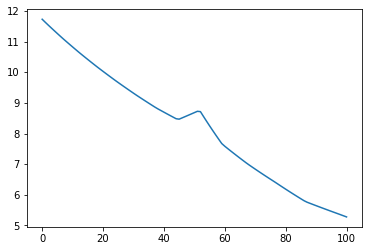

In [96]:
plt.plot(Et)

In [20]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [21]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

Text(0.5, 0, 'Year')

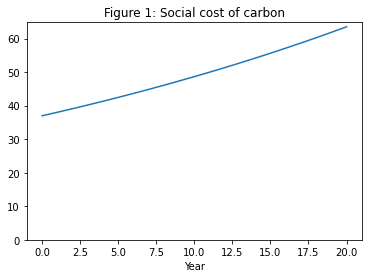

In [123]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [61]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

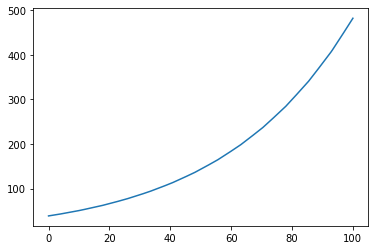

In [40]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [45]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [102]:
(1-δ/(α-ioverk))/ioverk

6.666666666666668

In [114]:
-0.0429 + ioverk - κ/2.*ioverk**2

0.02009865

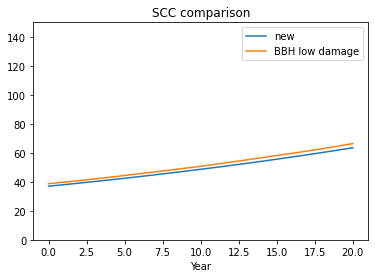

In [124]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

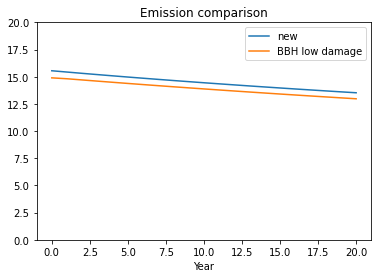

In [71]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [66]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])